<a href="https://colab.research.google.com/github/Safiullah-Rahu/Code/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/NLP_Week4_Exercise_Shakespeare_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow as tf
### YOUR CODE HERE
# Figure out how to import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-08-11 18:25:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c08::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-08-11 18:25:49 (136 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
model = Sequential()
model.add(Embedding(13000, 256, input_length=max_sequence_len - 1))
model.add(tf.keras.layers.Conv1D(128, 5, strides=1, activation='relu', padding='same'))
model.add(tf.keras.layers.Conv1D(64, 5, strides=1, activation='relu', padding='same'))
#model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(Bidirectional(LSTM(180, return_sequences=True, input_shape=(128,1))))
model.add(Dropout(0.2))
model.add(LSTM(158, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(196))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))


model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 256)           3328000   
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 128)           163968    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            41024     
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 360)           352800    
_________________________________________________________________
dropout (Dropout)            (None, 10, 360)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 158)           328008    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 158)           0

In [5]:
 history = model.fit(predictors, label, epochs=200, verbose=1)

Epoch 1/200
484/484 [==============================] - 57s 42ms/step - loss: 6.9826 - accuracy: 0.0211
Epoch 2/200
484/484 [==============================] - 19s 40ms/step - loss: 6.4863 - accuracy: 0.0234
Epoch 3/200
484/484 [==============================] - 20s 40ms/step - loss: 6.3506 - accuracy: 0.0220
Epoch 4/200
484/484 [==============================] - 20s 42ms/step - loss: 6.2804 - accuracy: 0.0248
Epoch 5/200
484/484 [==============================] - 20s 41ms/step - loss: 6.1482 - accuracy: 0.0291
Epoch 6/200
484/484 [==============================] - 19s 40ms/step - loss: 6.0497 - accuracy: 0.0360
Epoch 7/200
484/484 [==============================] - 20s 42ms/step - loss: 5.9634 - accuracy: 0.0421
Epoch 8/200
484/484 [==============================] - 20s 41ms/step - loss: 5.8818 - accuracy: 0.0458
Epoch 9/200
484/484 [==============================] - 19s 40ms/step - loss: 5.8079 - accuracy: 0.0514
Epoch 10/200
484/484 [==============================] - 20s 41ms/step - l

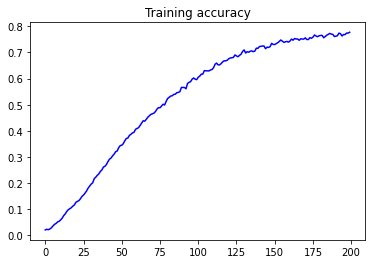

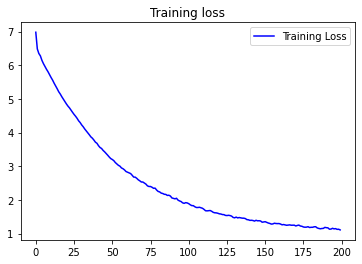

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [15]:
seed_text = "i carry your heart with me"
next_words = 25
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


i carry your heart with me so quickly asleep sky leaves kill his influence is love and other youth as made meet rolling as brought to rolling as nothing grows rare
